# Tutorial 4b: Parameter estimation with Markov chain Monte Carlo

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t4a_param_est_with_mcmc.ipynb).*

In [2]:
import collections
import itertools

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st

# Numerical differentiation packages
import numdifftools as ndt

# Our main MCMC package
import emcee

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Corner is useful for displaying MCMC results
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

In this tutorial, we will learn how to use **Markov chain Monte Carlo** to do parameter estimation.  To get the basic idea behind MCMC, imagine for a moment that we can draw samples out of the posterior distribution.  This means that the probability of choosing given values of a set of parameters is proportional to the posterior probability of that set of values.  If we drew many many such samples, we could reconstruct the posterior from the samples, e.g., by making histograms.  That's a big thing to image: that we can draw properly weighted samples.  But, it turns out that we can! That is what MCMC allows us to do.

We will discuss the theory behind this seemingly miraculous capability in lecture.  For today, we will just use the fact that we can do the sampling to learn about posterior distributions in the context of parameter estimation.  We will use the [`emcee` package](http://dan.iel.fm/emcee/current/) to do our sampling by MCMC.

## The data set
We will use the data set from the [previous tutorial](t4a_param_est_mle.html) from Singer, et al., while it is still fresh in our minds.  We can borrow the log posterior functions we coded up in that tutorial for use here.  First, we'll load in the data.

In [3]:
# Load DataFrame
df = pd.read_csv('../data/singer_et_al/singer_transcript_counts.csv',
                comment='#')

As a reminder, here are the ECDFs.

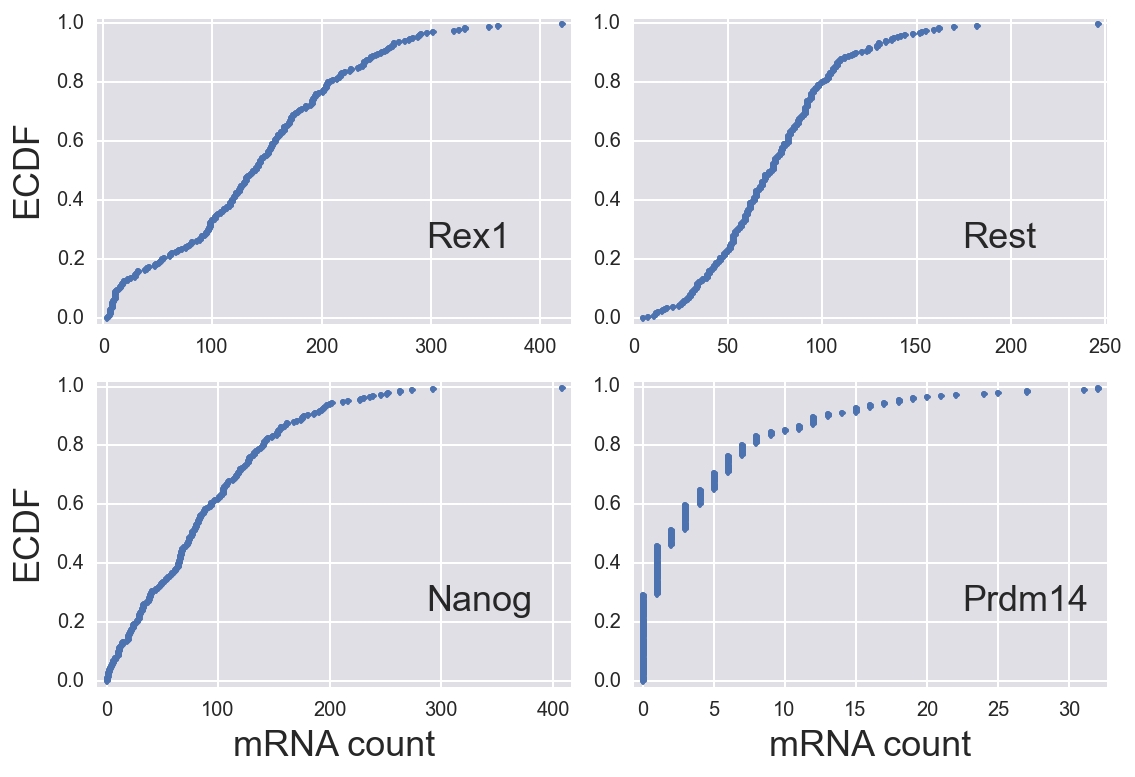

In [4]:
fig, ax = plt.subplots(2, 2)
sp_inds = list(itertools.product([0,1], [0,1]))

for i, gene in enumerate(df.columns):
    # Build ECDF
    y = np.arange(len(df[gene])) / len(df[gene])
    x = np.sort(df[gene].values)
    
    # Plot
    ax[sp_inds[i]].plot(x, y, '.')
    ax[sp_inds[i]].text(0.7, 0.25, gene, transform=ax[sp_inds[i]].transAxes,
                       fontsize=18)
    ax[sp_inds[i]].margins(0.02)
    
# Clean up
for i in [0,1]:
    ax[1,i].set_xlabel('mRNA count')
    ax[i,0].set_ylabel('ECDF')
plt.tight_layout()

## The posterior
We derived last time that the posterior distributions for a single negative binomial and double-binomial model are respectively

\begin{align}
P(r, p \mid \mathbf{n}) &\propto \prod_{n\in\mathbf{n}} \frac{(n + r - 1)!}{n!(r-1)!}\,p^r(1-p)^n,\\[2em]
P(r_1, r_2, p_1, p_2, f\mid n) &\propto 
f\,\frac{(n + r_1 - 1)!}{n!\,(r_1-1)!}\,p_1^{r_1}(1-p_1)^{n} \\[1em]
&\;\;\;\;+ (1-f) \frac{(n + r_2 - 1)!}{n!\,(r_2-1)!}\,p_2^{r_2}(1-p_2)^{n}.
\end{align}

As with our quest to find the MAP by optimization, we need to code up the log posterior for MCMC.  Conveniently, `emcee` uses the same API for the posterior definition as the `scipy.optimize` does.  We will again specify that $p_1 > p_2$.

In [9]:
def log_posterior(params, n):
    """
    Log posterior for MLE of Singer data.
    """
    r, p = params
    
    # Zero probability of having p < 0 or p > 1
    if p < 0 or p > 1:
        return -np.inf
    
    # Zero probability of r < 0
    if r < 0:
        return -np.inf

    return st.nbinom.logpmf(n, r, p).sum()

    
def neg_log_posterior(params, n):
    """
    Negative log posterior for MLE of Singer data.
    """
    return -log_posterior(params, n)


def log_posterior_bimodal(params, n):
    """
    Log of posterior for linear combination of neg. binomials.
    """
    r_1, r_2, p_1, p_2, f = params
    
    if (f < 0) or (f > 1):
        return -np.inf
    
    if (r_1 < 0) or (r_2 < 0) or (p_1 < p_2) or (p_2 < 0) or (p_1 > 1):
        return -np.inf
    
    return np.log(f * st.nbinom.pmf(n, r_1, p_1)
                  + (1-f) * st.nbinom.pmf(n, r_2, p_2)).sum()


def neg_log_posterior_bimodal(params, n):
    """
    Negative log posterior for linear combination of neg. binomials.
    """
    return -log_posterior_bimodal(params, n)

## Sampling the posterior with MCMC
We now set up the Markov chain Monte Carlo calculation.  MCMC works by having a "walker" move around parameter space.  I.e., a walker samples the posterior by jumping from one set of parameter values to another with the appropriate probabilistic weighting of the jumps.  The algorithm employed by `emcee`, [the affine invariance MCMC sampler](http://msp.berkeley.edu/camcos/2010/5-1/p04.xhtml) relies on multiple walkers sampling in parallel.  We therefore have to specify how many walkers we want.  It is usually a good idea to have many, like at least twice the number of parameters, walkers for this algorithm.  In addition to the number of walkers, we also need to specify
* The number of parameters in the posterior.
* The number of "burn" steps.  You want the walkers to be sampling properly, and you don't know where to start them to do so, you throw out the first set of samples.  These are called burn steps, and the process is called "burning in" the walkers.
* The number of steps to take after burn-in.

So, let's specify these are we set up our calculation.

In [31]:
n_dim = 2        # number of parameters in the model (r and p)
n_walkers = 50   # number of MCMC walkers
n_burn = 500     # "burn-in" period to let chains stabilize
n_steps = 5000   # number of MCMC steps to take after burn-in

Next, for consistency, I will seed the random number generator so we can compare our results as we go through the tutorial.

In [32]:
np.random.seed(42)

Now, we need to specify where in parameter space we will start each of our 50 walkers.  We will randomly draw the starting point for $p$ out of a uniform distribution on $[0,1]$.  Since $r$ can take any positive value, we will dray its starting points out of an exponential distribution with mean of 1.  Though we've made this choice, we could choose many other starting points.  We could, for example, find the MAP, and then start our walkers from its vicinity.  This is often done to reduce burn-in time.

In [33]:
# p0[i,j] is the starting point for walk i along variable j.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.exponential(0.1, n_walkers)            # r
p0[:,1] = np.random.uniform(0, 1, n_walkers)             # p

Now we are ready to instantiate our sampler, an `emcee.EnsembleSampler` instance.  The syntax is straightforward.  It takes are required arguments the number of walkers, the number of dimensions (that is, the number of parameters), and a function giving the log of the posterior.  The kwarg `args` is as in `scipy.optimize.minimize()`; it is a tuple of other arguments to be passed into your log posterior function.  These arguments almost always include your data.  Finally, the `threads` kwarg is useful.  You can specify how many cores of your machine you want to use for the calculation, and the MCMC sampling will be done with parallel processing.  It is a good idea to choose two less than the number of cores you have on your machine.  For me, I choose six threads.

For this example, we will look at the Prdm14 expression.

In [34]:
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, 
                                args=(df['Prdm14'],), threads=6)

Now, we'll do the burn-in.  This is just using the `run_mcmc()` method of the sampler without storing the results.  The first argument to the `run_mcmc()` method is the starting point of the parameter values.  The second is the number of MCMC steps to take (in this case `n_burn`).  We use the kwarg `storechain=False` to indicate that we are not saving the samples.  The sample outputs the ending position (set of parameter values), probability (posterior probability), and the state of the random number generator.  We need to keep the positions of the walkers because this is where we start after burn-in.

In [35]:
# Do burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

Now that burn-in is complete, we can run the sampler to generate the MCMC samples!

In [36]:
# Sample again, starting from end burn-in state
_ = sampler.run_mcmc(pos, n_steps)

## Parsing MCMC results

The `sampler` object has lots of properties and methods that are useful to us.  The most useful are `sampler.chain` and `sampler.flatchain`, which are the samples themselves.  Let's look at these briefly.

In [37]:
print(sampler.chain.shape)
print(sampler.flatchain.shape)

(50, 5000, 2)
(250000, 2)


As we can see, `sampler.chain` has the samples for each of the 50 walkers, and `sampler.flatchain` is a flattened array of the samples.

Let's look at the trace of a single walker for each of our two parameters ($r$ and $p$).

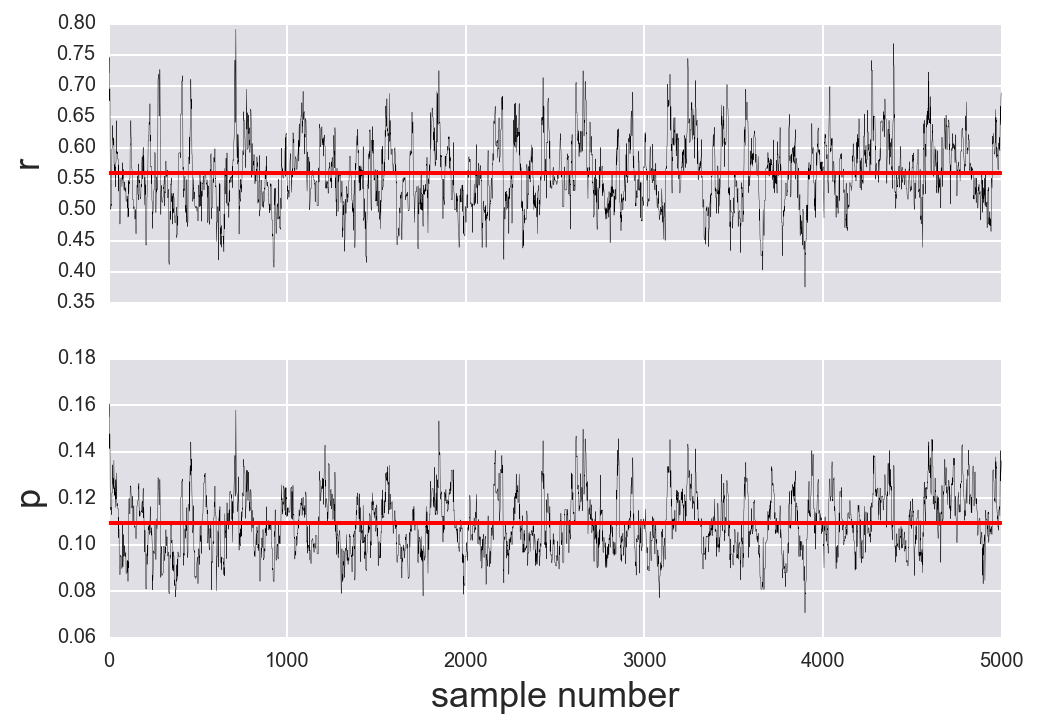

In [38]:
fig, ax = plt.subplots(2, 1, sharex=True)
for i in [0, 1]:
    ax[i].plot(sampler.chain[0,:,i], 'k-', lw=0.2)
    ax[i].plot([0, n_steps-1], 
             [sampler.chain[0,:,i].mean(), sampler.chain[0,:,i].mean()], 'r-')

ax[1].set_xlabel('sample number')
ax[0].set_ylabel('r')
ax[1].set_ylabel('p')

The samplers fluctuate around the mean, which is a sign, but definitely not a guarantee, that the sampler has converged, i.e., that it is accurately sampling the posterior.

Now that we know how to access the MCMC samples, let's start learning some more about our posterior. For example, we can approximate the MAP as the parameter values that were visited by the sampler that had the highest probability.  We can access the probabilities with the `sampler.lnprobability` and `sampler.flatlnprobability` attributes.

In [39]:
# Get the index of the most probable parameter set
max_ind = np.argmax(sampler.flatlnprobability)

# Pull out values.
r_MAP, p_MAP = sampler.flatchain[max_ind,:]

# Print the results
print("""
Most probable parameter values:
r:  {0:.3f}
p: {1:.3f}
""".format(r_MAP, p_MAP))


Most probable parameter values:
r:  0.553
p: 0.109



These are identical to [what we got via optimization](t4a_param_est_mle.html#Numerical-optimization-to-find-the-MAP)!

But we did a lot of work to do these calculations. Let's take full advantage of them!

An obvious thing to do is to compute an error bar. If make the assumption (as before) that the posterior is approximately Gaussian, then the error bar is just given by the standard deviation of this Gaussian.  Since we have so many samples, this is just the standard deviation of all the samples! (Note: One of the main reasons we did MCMC is so that we do not have to make approximations about things being Gaussian, so we get more information from actually plotting the posterior.)

In [41]:
# Compute error bars by taking standard deviation
r_err, p_err = sampler.flatchain.std(axis=0)

print('Error bars:\n', r_err, p_err)

Error bars:
 0.059505275156 0.0132304628567


These are quite close to [what we got via optimization](t4a_param_est_mle.html#Numerical-optimization-to-find-the-MAP).  This suggests that the posterior is accurately approximated by a Gaussian.

But, we have sampled the entire posterior.  We know everything!  I know, I've said that before just when we wrote down the posterior.  But now, we see one of the great powers of MCMC.  

Question: How do we get a marginalized distribution?  Answer: Ignore variables we don't care about!  Remember, the sampler considers all of the parameters as it steps through parameter space, so the influence of all parameters area always there.  We just need to slice out samples of what we want to get marginalized posteriors.  We can get the marginalized posterior of $r$ and $p$ and plot histograms.

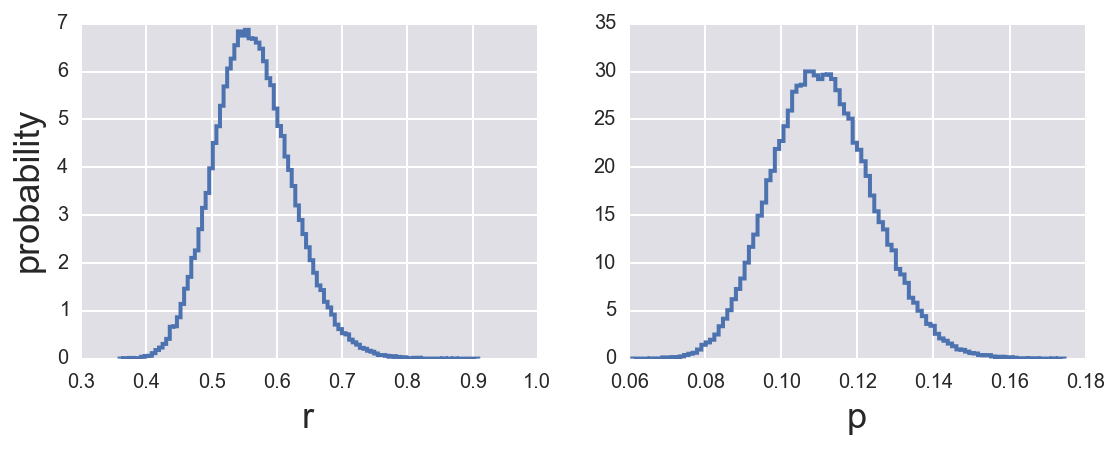

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))

for i in [0, 1]:
    # Plot the histogram as a step plot
    _ = ax[i].hist(sampler.flatchain[:,i], bins=100, normed=True, 
                   histtype='step', lw=2)

ax[0].set_xlabel('r')
ax[1].set_xlabel('p')
ax[0].set_ylabel('probability')

We can get a nice summary of the posterior using the `corner` module.

/Users/Justin/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/Justin/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


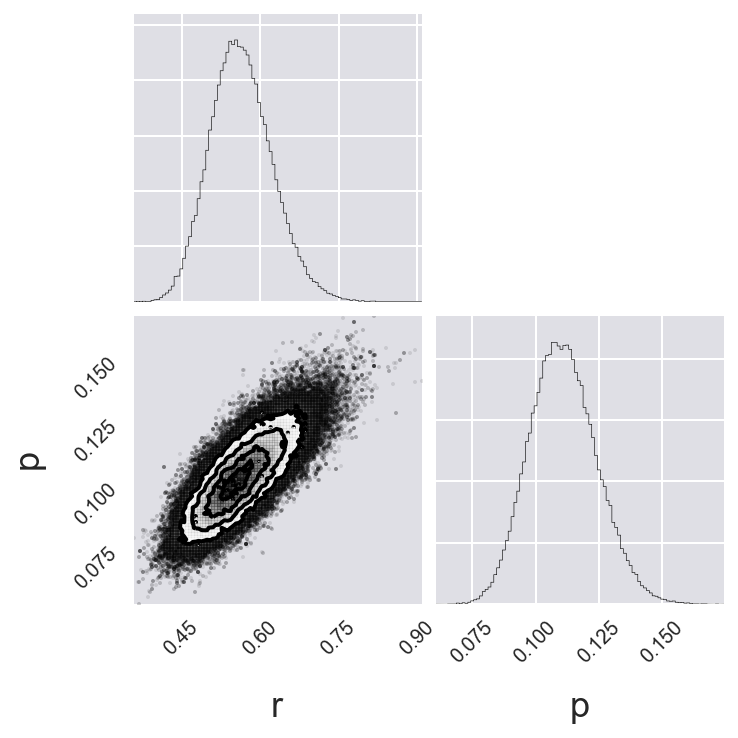

In [50]:
fig = corner.corner(sampler.flatchain, labels=['r', 'p'], bins=100)

For the case where we have two parameters, we get the full posterior as a contour plot and the marginalized posteriors as well.

### MLE with a double negative binomial
We can repeat the analysis with the Rex1 data sent using a linear combination of negative binomials as the likelihood/posterior.  The set-up and calculation by the sampler is done in the following code cell.  I introduce some data structures I like to employ to keep me organized when I do MCMC with `emcee`.  In particular, I set up my parameters and starting values in an `OrderedDict`.  The keys are the variable names and the entries are tuples.  The first entry in the tuple is the function used to draw the random starting positions of the walker, and the second entry in the tuple is a tuple containing parameters to be passed to that function.

In [51]:
# Parameters and how we start them
params = collections.OrderedDict(
        [('r1', (np.random.exponential, (1,))),
         ('r2', (np.random.exponential, (1,))),
         ('p1', (np.random.uniform, (0, 1))),
         ('p2', (np.random.uniform, (0, 1))),
         ('f', (np.random.uniform, (0, 1)))])

# Define walker settings
n_dim = len(params)
n_walkers = 50
n_burn = 500
n_steps = 5000

# Keep a set of param names handy
param_names = list(params.keys())

# Seed random number generator for reproducibility
np.random.seed(42)

# p0[i,j] is the starting point for walk i along variable j.
p0 = np.empty((n_walkers, n_dim))
for i, key in enumerate(params):
    p0[:,i] = params[key][0](*(params[key][1] + (n_walkers,)))

# Make sure p1 > p2
p0[:,2], p0[:,3] = np.maximum(p0[:,2], p0[:,3]), np.minimum(p0[:,2], p0[:,3])

# Set up the EnsembleSampler instance
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior_bimodal, 
                                args=(df['Rex1'],), threads=6)

# Do burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

# Sample again, starting from end burn-in state
_ = sampler.run_mcmc(pos, n_steps)

Let's just cut to the chase and look at the corner plot.

/Users/Justin/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/Justin/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


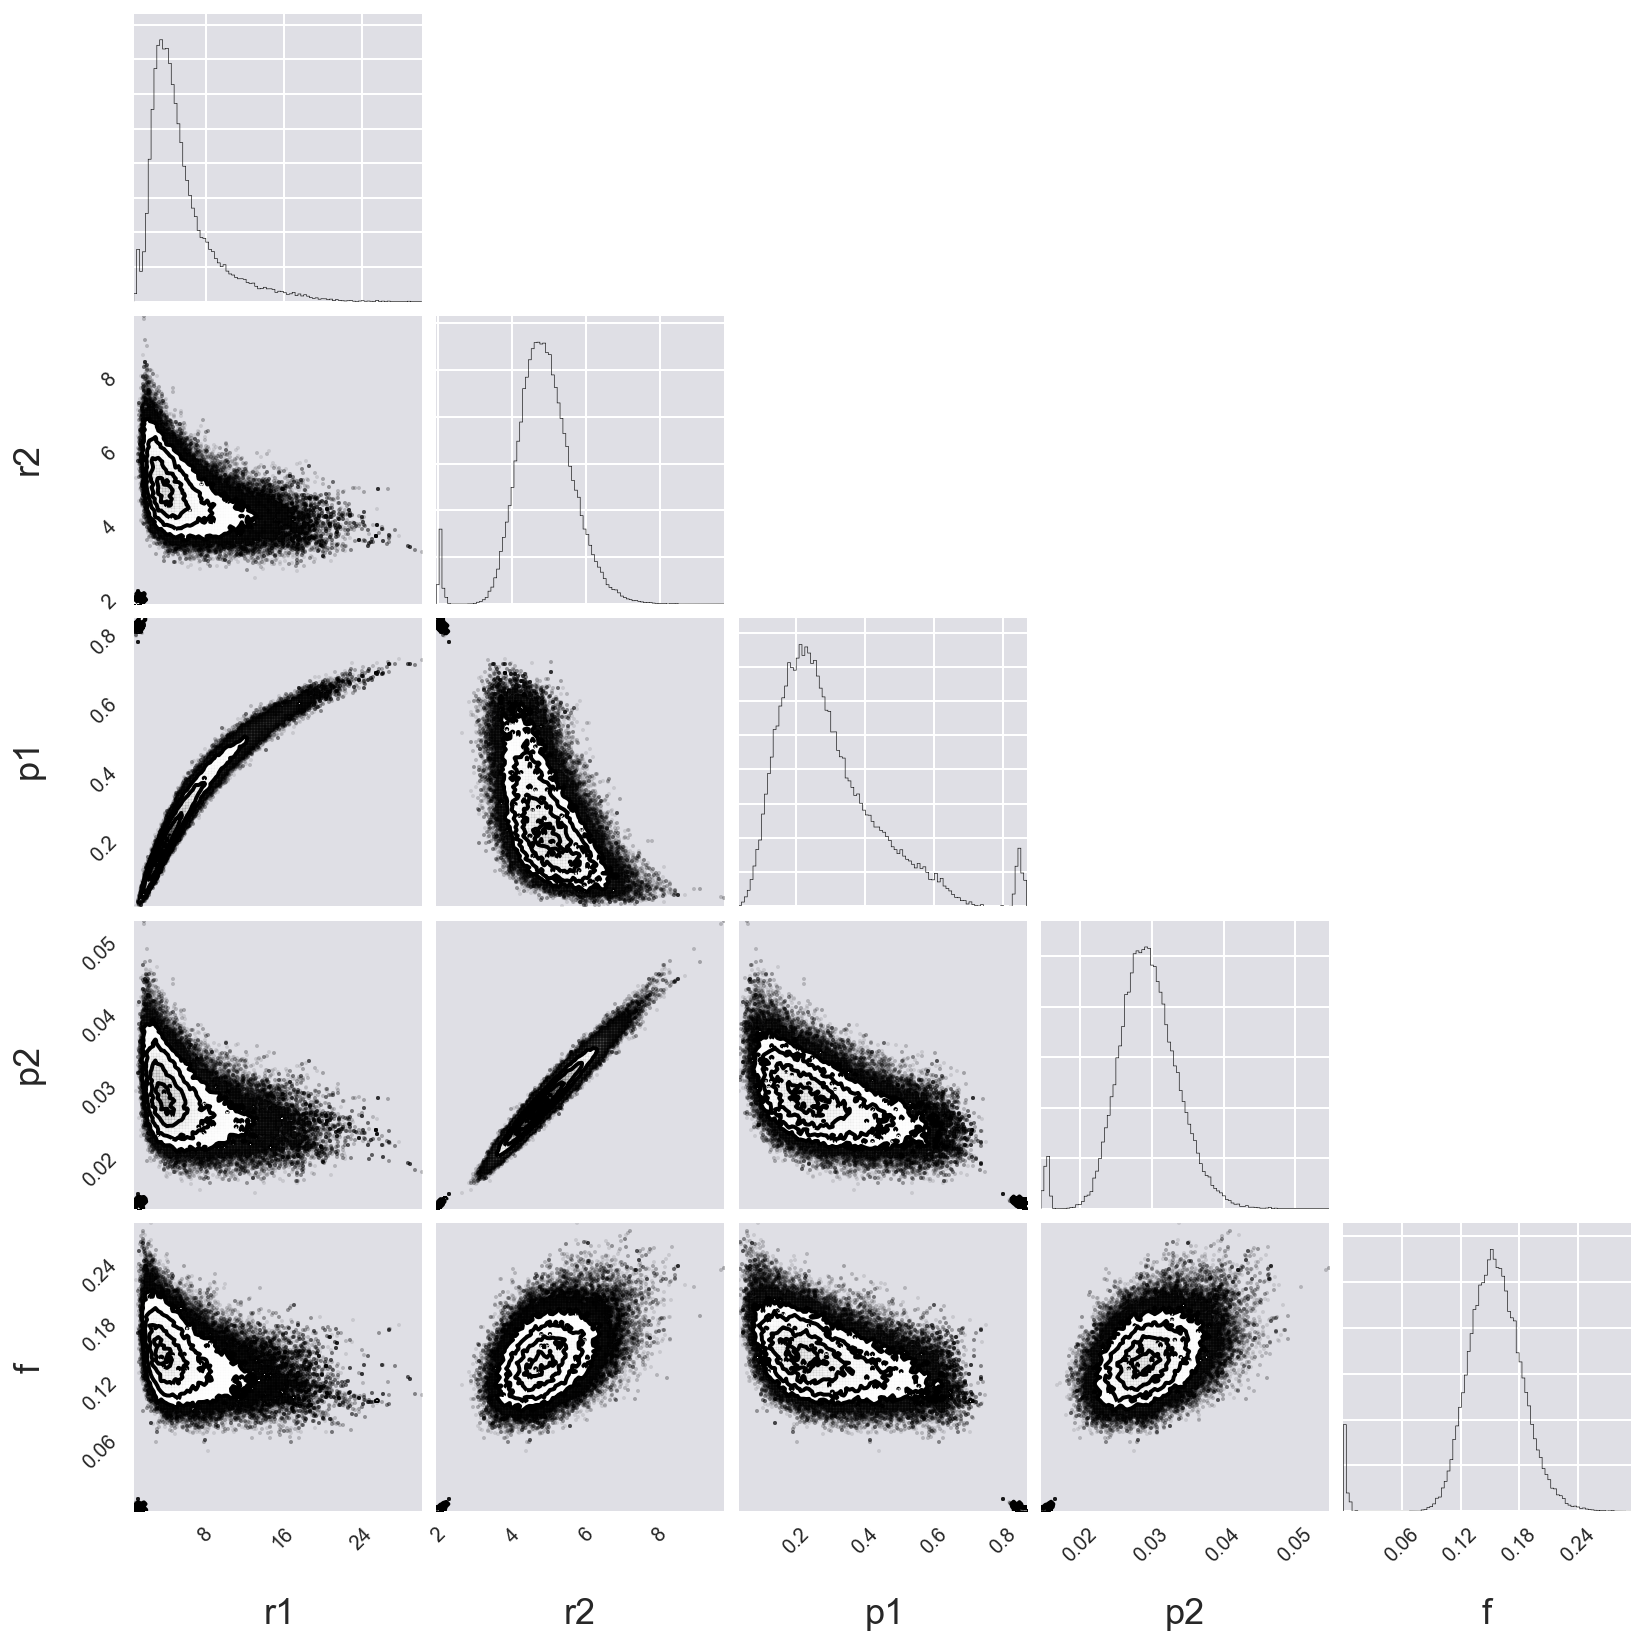

In [52]:
# Use triangle.corner to make summary plot
fig = corner.corner(sampler.flatchain, labels=param_names, bins=100)

First off, the small set of samples away from the rest is a sign that one or a few of the walkers was not completely burned in.  For the purposes of expedience in the tutorial, we are taking few samples and even fewer burn-in steps.  You can fix this by boosting `n_burn`.

Now, we notice very strong correlation between $p_2$ and $r_2$, and also between $p_1$ and $r_1$.  We also see some strongly non-Gaussian shapes to the posteriors in the contour plots.  We also start to see tails in the marginalized posteriors.  These are all immediately apparent from the MCMC samples, further demonstrating its tremendous utility.